In [1]:
from importlib import reload
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

In [2]:
# import NN architectures for speech recognition
import models as M
# import function for training acoustic model
import train_utils as T

import utils as U

import data_generator as DG

print()
# U.config_GPU(gpu_memory_fraction=0.5)
U.config_GPU(allow_growth = True)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.

/device:GPU:0


In [3]:
def reload_all():
    reload(U)
    reload(DG)
    reload(M)
    reload(T)

audio_gen_mfcc = None
audio_gen_spec = None
audio_gen_raw  = None

def init_gen(spectrogram=True, raw=False, max_length=None):
    print("Initializing Generator for ", 
          "Raw" if raw else
          ("MFCC" if not spectrogram else "Spectrogram"))
    if raw:
        audio_gen = DG.AudioGeneratorCached(spectrogram=False, raw=raw, minibatch_size=5)
    else:
        audio_gen = DG.AudioGeneratorCached(spectrogram=spectrogram, max_length=max_length, minibatch_size=32)
        
    audio_gen.load_train_data('train_corpus.json')
    audio_gen.load_validation_data('valid_corpus.json')
    return audio_gen

def init_gen_var(spectrogram=True, raw=False):
    global audio_gen_mfcc
    global audio_gen_spec
    global audio_gen_raw
    if raw:
        if not audio_gen_raw:
            audio_gen_raw = init_gen(raw=True)
    elif spectrogram:
        if not audio_gen_spec:
            audio_gen_spec = init_gen(spectrogram=True, max_length=250)
    else:
        if not audio_gen_mfcc:
            audio_gen_mfcc = init_gen(spectrogram=False)

def get_gen(spectrogram=True, raw=False):
    init_gen_var(spectrogram, raw)
    return audio_gen_raw if raw else (audio_gen_spec if spectrogram else audio_gen_mfcc)
        
                                      
model_names_to_compare = []

def train_model(model_builder, *args, spectrogram=True, raw=False, mfcc_concat=False, **kwargs):
    reload(M)
    reload(T)
    global audio_gen_mfcc
    global audio_gen_spec
    global audio_gen_raw
    init_gen_var(spectrogram, raw)
    name = T.train_model(audio_gen_raw if raw else (audio_gen_spec if spectrogram else audio_gen_mfcc), model_builder, *args, **kwargs)
    model_names_to_compare.append(name)    

In [4]:
def plot_comparison(model_names=None, *args, **kwargs):
    reload(T)
    
    if model_names is None:
        names = model_names_to_compare
        print_model_names(names)
    else:
        names = model_names
    pickles = []
    for name in names:
        pickles.append("results/" + name + ".pickle")
    T.plot_comparison(pickles=pickles, *args, **kwargs)
    
def print_model_names(model_names=None):
    print_list_of_strings(model_names if model_names is not None else model_names_to_compare)
    
    
def print_list_of_strings(list_of_strings):
    print("[", end="")
    first = True
    for name in list_of_strings:
        if not first:
            print(",")
            print(" ", end="")
        else:
            first = False
        print("\'"+name+"\'", end="")
    print("]")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 250, 161)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 250, 161, 1)  0           the_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 161, 20) 1020        reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 250, 161, 20) 80          conv2d_1[0][0]                   
__________________________________________________________________________________________________
reluC0 (Ac

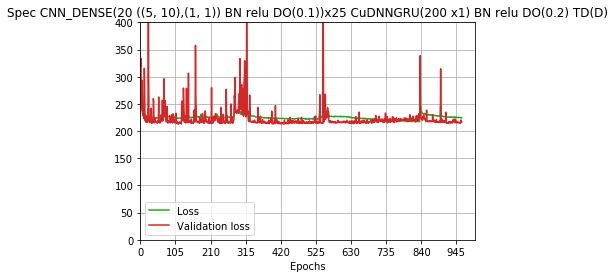

In [5]:
audio_gen_spec = None
from keras.optimizers import SGD

train_model(M.RNNModel(cnn_config=M.CNNConfig(filters=20,kernel_2d=(5,10), conv_stride_2d=(1,1), conv_border_mode="valid", 
                                              cnn_layers=25, cnn_dense=True,
                                              cnn_activation_before_bn_do=False, cnn_dropout_rate=0.1,
                                              cnn_do_bn_order=False), 
                       bd_merge=None, rnn_layers=1), 
#                        optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5), 
            epochs=1000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 250, 161)     0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 250, 161, 1)  0           the_input[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 250, 161, 20) 200         reshape_3[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 250, 161, 20) 80          conv2d_26[0][0]                  
__________________________________________________________________________________________________
reluC0 (Ac

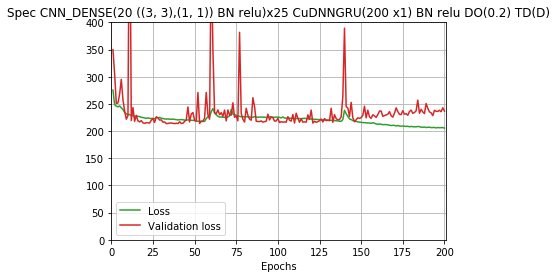

In [6]:
audio_gen_spec = None
from keras.optimizers import SGD

train_model(M.RNNModel(cnn_config=M.CNNConfig(filters=20,kernel_2d=(3,3), conv_stride_2d=(1,1), conv_border_mode="valid", 
                                              cnn_layers=25, cnn_dense=True,
                                              cnn_activation_before_bn_do=False, cnn_dropout_rate=0,
                                              cnn_do_bn_order=False), 
                       bd_merge=None, rnn_layers=1), 
#                        optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5), 
            epochs=200)

In [19]:
from utils import int_sequence_to_text

reload(M)
reload(T)
def test_gen():
    
    gen = DG.AudioGeneratorCached(spectrogram=True, max_length=200, sort_by_duration=True)
#     gen = DG.AudioGenerator(raw=True, minibatch_size=1, sort_by_duration=True)
    gen.load_train_data('train_corpus.json')
#     s_gen = DG.AudioGeneratorCached(spectrogram=True, minibatch_size=1, sort_by_duration=True)
#     s_gen.load_train_data('train_corpus.json')
#     m_gen = DG.AudioGeneratorCached(spectrogram=False, minibatch_size=1, sort_by_duration=True)
#     m_gen.load_train_data('train_corpus.json')
#     c_gen = DG.AudioGeneratorCached(spectrogram=True, mfcc_concat=True, minibatch_size=1, sort_by_duration=True)
#     c_gen.load_train_data('train_corpus.json')

# mfcc_audio_gen = DG.AudioGeneratorCached(spectrogram=False)
#     for i, j in zip(s_gen.next_train(), m_gen.next_train()):
#         break
    counter = 0
    for j in gen.next_train():
#         print(type(j), len(j), type(j[0]), type(j[1]))
#         print(j[0].keys())
#         print(j[1].keys())
        print(j[0]['the_input'].shape, j[0]['the_labels'].shape, end=' ')
        ints = j[0]['the_labels'][0]
        ints = [t+1 for t in ints]
        print("".join(int_sequence_to_text(ints)))
    
#         for m in range(0, j[0]['the_labels'].shape[1]):

#             print("{:02.0f}".format(j[0]['the_labels'][0][m]), end=' ')
#         print()
        counter += 1
        if counter > 30:
            break
        
#         break
# print(mfcc_audio_gen.next_train())

test_gen()

(20, 200, 161) (20, 43) 

KeyError: 29.0